In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20
0,Anhui,Mainland China,31.82570,117.2264,1,9,15,39,60,70,...,989,989,989,989,990,990,990,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,14,22,36,41,68,80,...,399,400,400,410,410,411,413,414,414,418
2,Chongqing,Mainland China,30.05720,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,1,5,10,18,35,59,...,293,294,294,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91
5,Guangdong,Mainland China,23.34170,113.4244,26,32,53,78,111,151,...,1345,1347,1347,1347,1348,1349,1349,1350,1350,1350
6,Guangxi,Mainland China,23.82980,108.7881,2,5,23,23,36,46,...,251,252,252,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,1,1,2,8,13,18,...,311,311,312,317,318,318,318,318,318,318


In [3]:
for index, row in df.iterrows():
    if row['Country/Region'] == 'Others':
        a = row['Province/State']
        df.loc[index, 'Country/Region'] = a

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 20 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 20]
cases


Total number of cases (in countries with at least 20 cases) as of 3/4/20


,3/4/20
Country/Region,
Mainland China,80271
South Korea,5621
Italy,3089
Iran,2922
Diamond Princess cruise ship,706
Japan,331
France,285
Germany,262
Spain,222


In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y)
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.9:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(np.log(2)/lpopt[1],2), 'days')
            logisticworked = True
            
    except:
        pass
        
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]))
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.9:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(np.log(2)/epopt[1],2), 'days')
            exponentialworked = True
            
    except:
        pass
            
    plt.title(country + ' COVID-19 Cases as of '+mostrecentdate, fontsize="x-large")
    plt.xlabel('Days')
    plt.ylabel('Total Cases')
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return np.log(2)/lpopt[1]
        else:
            return np.log(2)/epopt[1]
            
    if logisticworked:
        return np.log(2)/lpopt[1]
    
    if exponentialworked:
        return np.log(2)/epopt[1]


Mainland China

** Based on Logistic Fit **

	R^2: 0.993753197533
	Doubling Time:  3.23 days


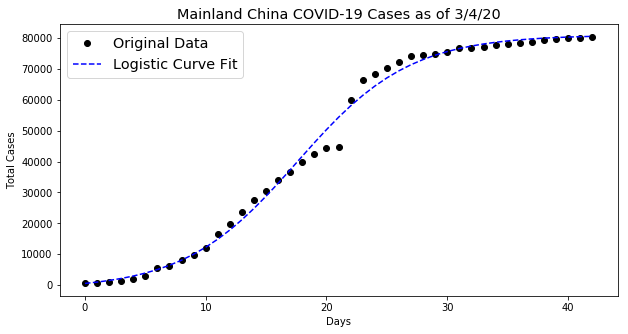



South Korea

** Based on Exponential Curve Fit **

	R^2: 0.985892347817
	Doubling Time:  3.42 days


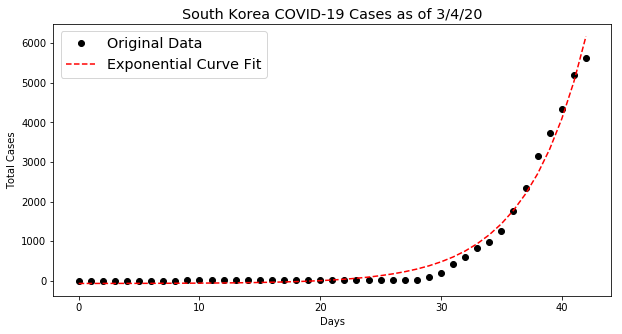



Italy

** Based on Exponential Curve Fit **

	R^2: 0.99327129231
	Doubling Time:  2.72 days


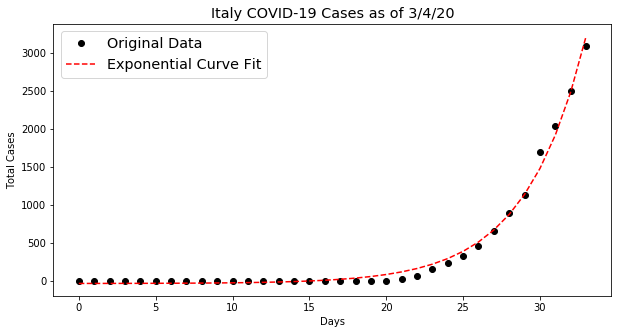



Iran

** Based on Logistic Fit **

	R^2: 0.998591407217
	Doubling Time:  1.12 days

** Based on Exponential Curve Fit **

	R^2: 0.992237039983
	Doubling Time:  1.92 days


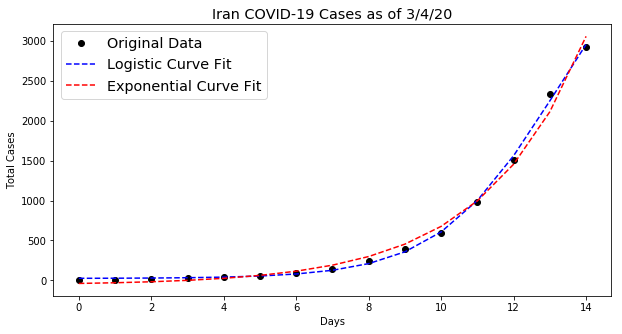



Diamond Princess cruise ship

** Based on Logistic Fit **

	R^2: 0.994833707411
	Doubling Time:  1.37 days


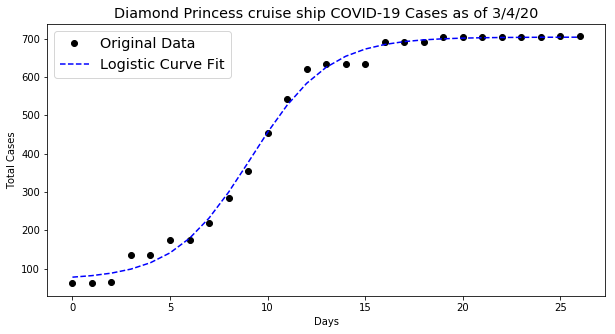



Japan

** Based on Logistic Fit **

	R^2: 0.993685939128
	Doubling Time:  4.11 days

** Based on Exponential Curve Fit **

	R^2: 0.987646253763
	Doubling Time:  7.63 days


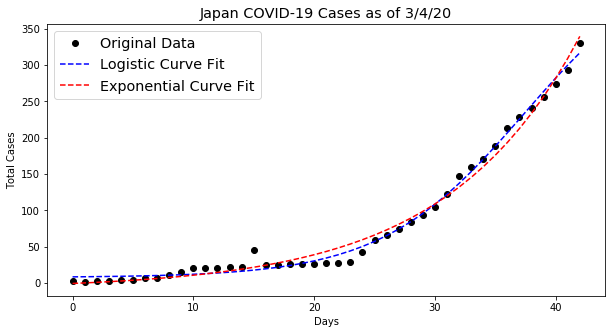



France

** Based on Exponential Curve Fit **

	R^2: 0.98161314163
	Doubling Time:  2.22 days


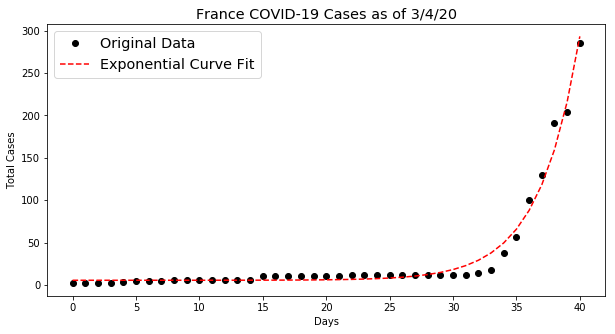



Germany

** Based on Exponential Curve Fit **

	R^2: 0.985471155253
	Doubling Time:  2.15 days


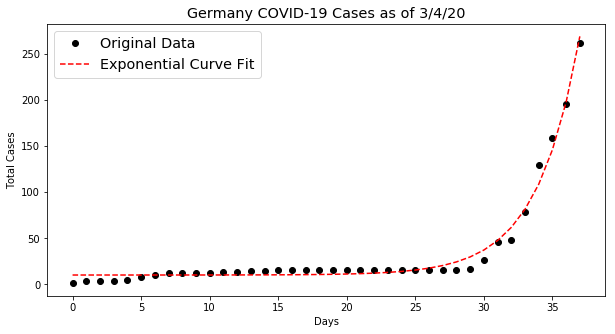



Spain

** Based on Exponential Curve Fit **

	R^2: 0.993011418934
	Doubling Time:  1.86 days


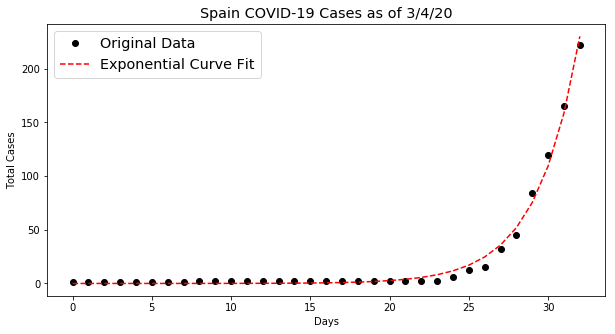



US

** Based on Exponential Curve Fit **

	R^2: 0.974660563536
	Doubling Time:  4.46 days


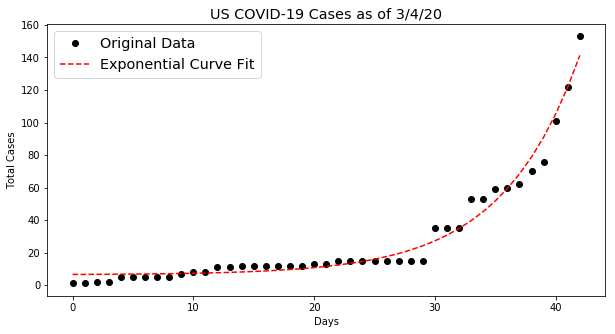



Singapore

** Based on Logistic Fit **

	R^2: 0.99208087006
	Doubling Time:  4.69 days

** Based on Exponential Curve Fit **

	R^2: 0.961645255084
	Doubling Time:  35.71 days


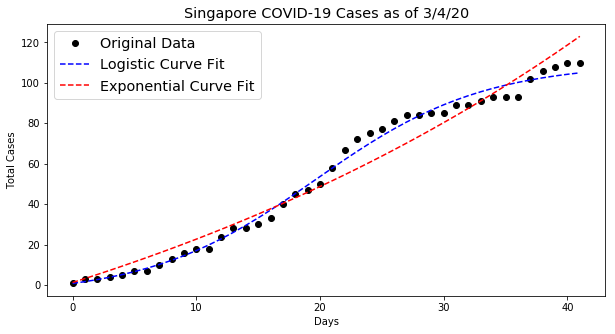



Hong Kong

** Based on Logistic Fit **

	R^2: 0.98960432948
	Doubling Time:  7.08 days

** Based on Exponential Curve Fit **

	R^2: 0.983596816204
	Doubling Time:  37.67 days


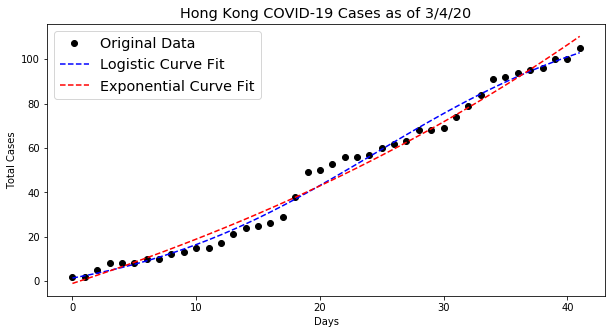



Switzerland

** Based on Logistic Fit **

	R^2: 0.995015959564
	Doubling Time:  1.86 days

** Based on Exponential Curve Fit **

	R^2: 0.995015960054
	Doubling Time:  1.86 days


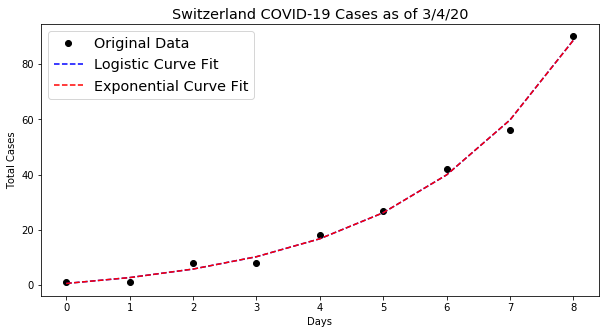



UK

** Based on Exponential Curve Fit **

	R^2: 0.963441265568
	Doubling Time:  2.01 days


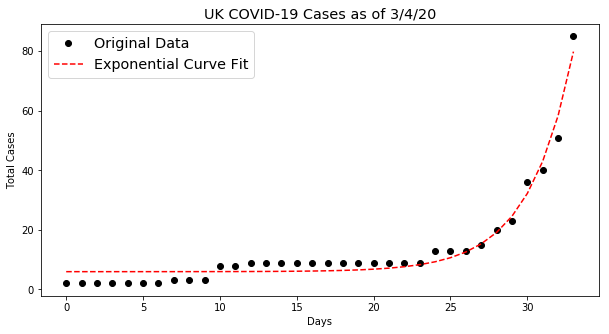



Norway

** Based on Logistic Fit **

	R^2: 0.975049485592
	Doubling Time:  2.08 days

** Based on Exponential Curve Fit **

	R^2: 0.975049486359
	Doubling Time:  2.08 days


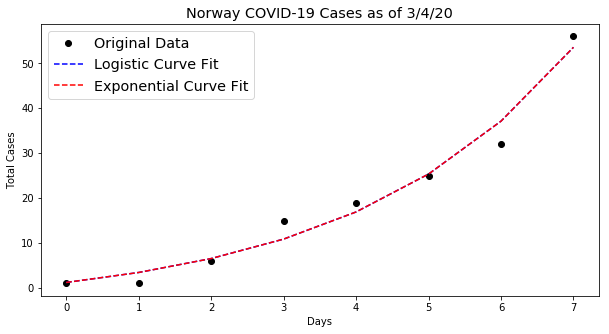



Kuwait

** Based on Logistic Fit **

	R^2: 0.965416467103
	Doubling Time:  1.22 days


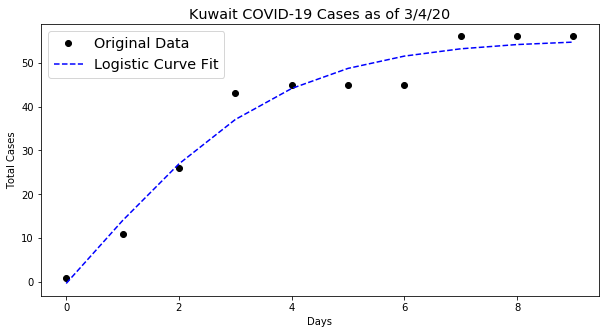



Bahrain


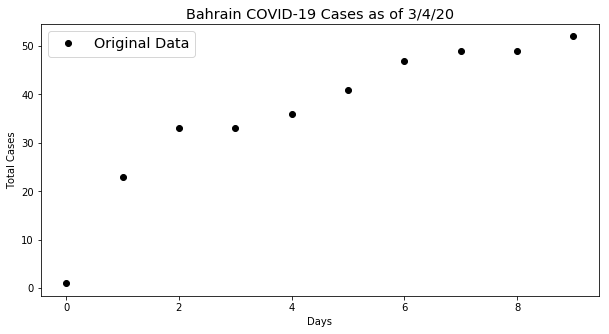



Australia


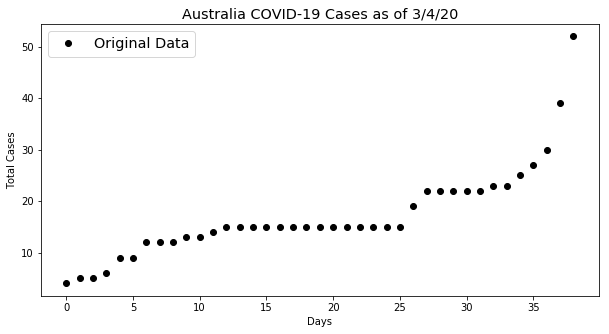



Malaysia


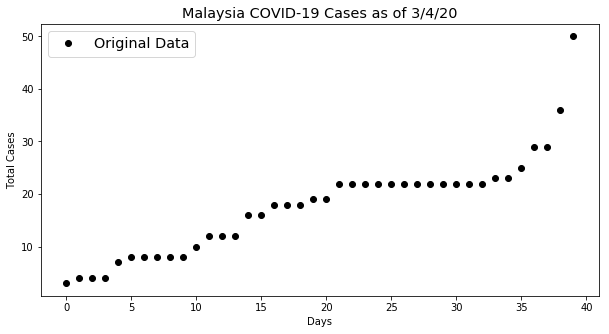



Thailand

** Based on Logistic Fit **

	R^2: 0.977545994848
	Doubling Time:  12.16 days


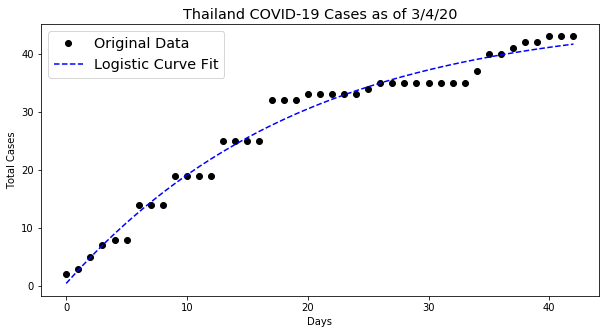



Taiwan

** Based on Logistic Fit **

	R^2: 0.981513112892
	Doubling Time:  28.89 days

** Based on Exponential Curve Fit **

	R^2: 0.981513113518
	Doubling Time:  28.89 days


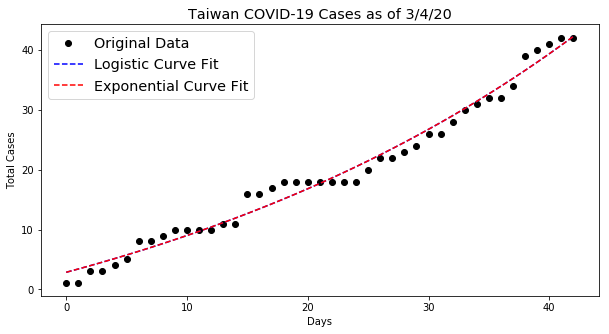



Netherlands

** Based on Logistic Fit **

	R^2: 0.993608575146
	Doubling Time:  2.07 days

** Based on Exponential Curve Fit **

	R^2: 0.993608575614
	Doubling Time:  2.07 days


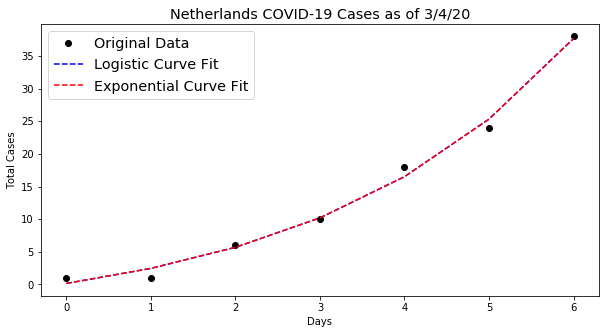



Iraq

** Based on Logistic Fit **

	R^2: 0.992658603549
	Doubling Time:  1.09 days

** Based on Exponential Curve Fit **

	R^2: 0.980450634268
	Doubling Time:  4.4 days


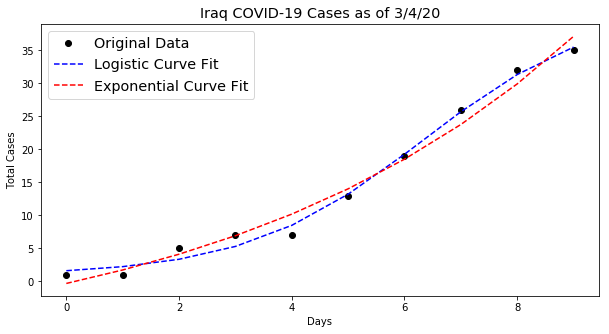



Sweden

** Based on Exponential Curve Fit **

	R^2: 0.976957209442
	Doubling Time:  1.99 days


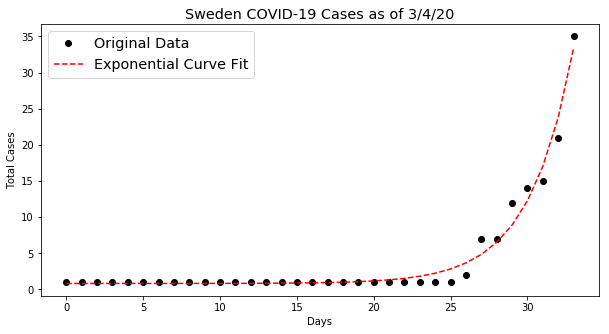



Canada

** Based on Exponential Curve Fit **

	R^2: 0.949915378736
	Doubling Time:  4.15 days


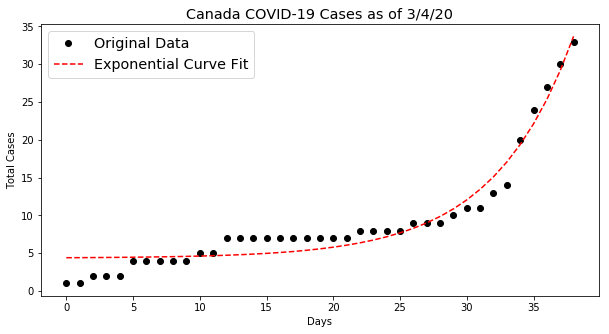



Austria

** Based on Logistic Fit **

	R^2: 0.982073568477
	Doubling Time:  1.26 days

** Based on Exponential Curve Fit **

	R^2: 0.977174126584
	Doubling Time:  3.06 days


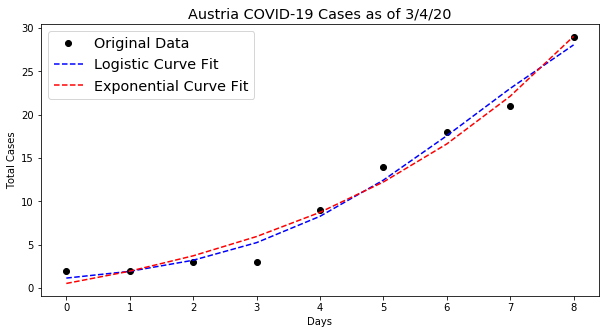



India


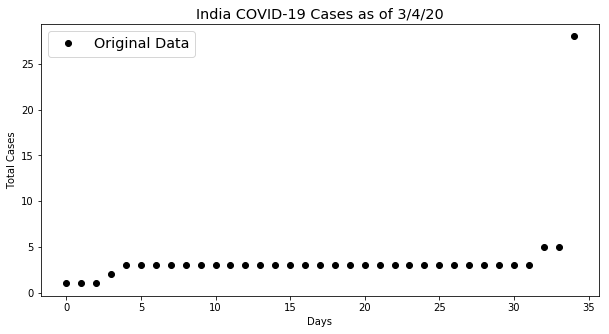



United Arab Emirates

** Based on Logistic Fit **

	R^2: 0.962071422403
	Doubling Time:  6.48 days

** Based on Exponential Curve Fit **

	R^2: 0.962071423222
	Doubling Time:  6.48 days


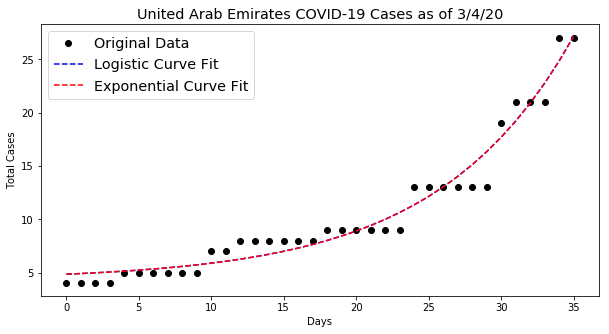



Iceland

** Based on Exponential Curve Fit **

	R^2: 0.997594902409
	Doubling Time:  0.83 days


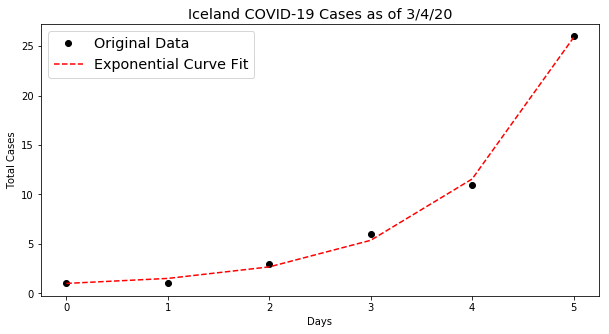



Belgium

** Based on Exponential Curve Fit **

	R^2: 0.986570854896
	Doubling Time:  1.01 days


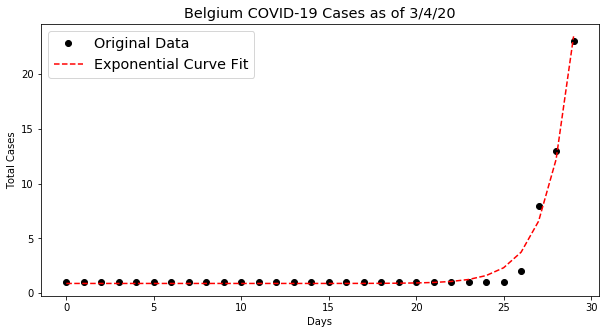

In [6]:
topcountries = cases.index
doublingtime = []
countries = []
print();

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a)
    print('\n')

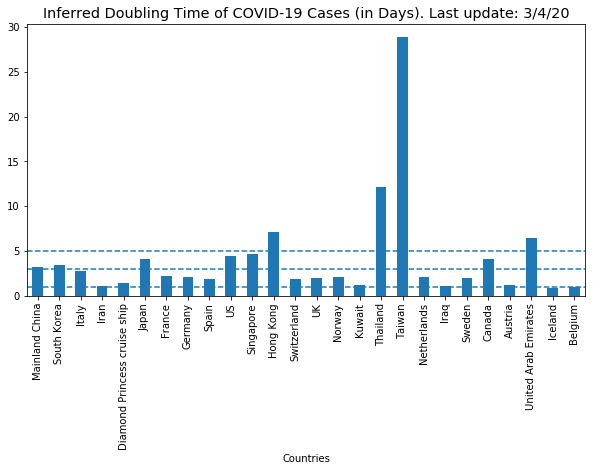

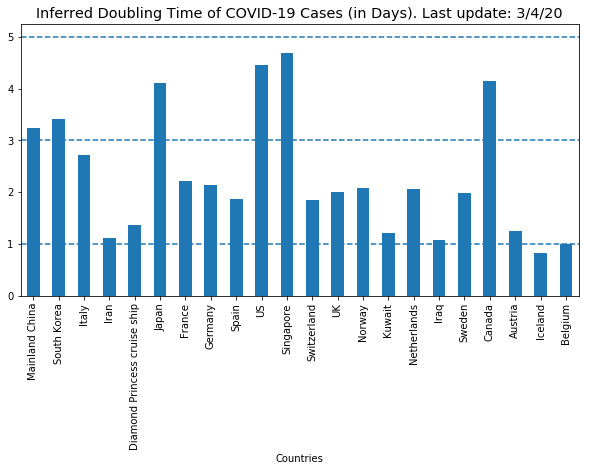

In [7]:
d = {'Countries': countries, 'Doubling Time': doublingtime}

dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', legend=False,figsize=(10,5));
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of COVID-19 Cases (in Days). Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', legend=False,figsize=(10,5));
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of COVID-19 Cases (in Days). Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

In [8]:
uscases = df[df['Country/Region'] == 'US']

uscasesbystate = uscases.copy()
uscasesbystate['Province/State'] = uscasesbystate['Province/State'].str.split(", ", expand=True)[1]

usstatesummary = uscasesbystate.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state')
usstatesummary


Number of confirmed US COVID-19 cases by state


,3/4/20
Province/State,
WA,39
CA,35
NY,11
IL,4
FL,3
OR,3
AZ,2
RI,2
GA,2


US state:  WA

** Based on Exponential Curve Fit **

	R^2: 0.987866528439
	Doubling Time:  1.47 days


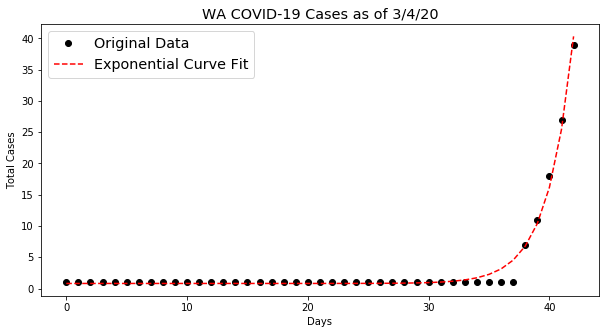

US state:  CA


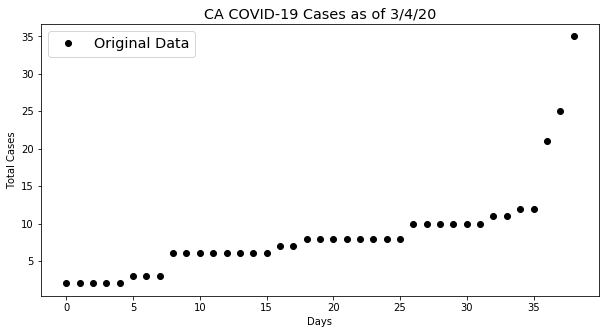

In [9]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] > 20]

for state in topusstates.index.values:
    print('US state: ', state)
    plotCases(uscasesbystate,'Province/State', state)

In [10]:
print('\nUS Locations with 5 or more confirmed cases')

uscitysummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = uscitysummary.columns[0]
uscitysummary = uscitysummary.sort_values(by = mostrecentdate, ascending = False)
uscitysummary = uscitysummary[uscitysummary[mostrecentdate] >= 5]

uscitysummary


US Locations with 5 or more confirmed cases


,3/4/20
Province/State,
Unassigned Location (From Diamond Princess),45
"King County, WA",31
"Santa Clara, CA",11
"Westchester County, NY",10
"Snohomish County, WA",8
"Los Angeles, CA",7
